In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

In [ ]:
# Definir el modelo de la red neuronal para la ecuación del calor
class BurgerEquationNN(nn.Module):
    def __init__(self, num_hidden_layers=10, num_neurons=60):
        super(BurgerEquationNN, self).__init__()

        layers = [nn.Linear(3, num_neurons), nn.Tanh()]  # Entrada (x, t) -> primera capa oculta
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(num_neurons, num_neurons))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(num_neurons, 2))  # Última capa -> salida u(x, t)
        self.model = nn.Sequential(*layers)

    def forward(self, x, y, t):
        inputs = torch.cat([x, y, t], dim=1)  # Concatenar x,y y t
        output = self.model(inputs)
        u = output[:, 0].reshape(-1, 1)  # Componente u
        v = output[:, 1].reshape(-1, 1)  # Componente v

        return u,v

In [ ]:
class PINNLoss(nn.Module):
    def __init__(self, model, nu,w1,w2,w3):
        super(PINNLoss, self).__init__()
        self.model = model.cuda()  # Mover el modelo a la GPU
        self.nu = nu
        self.w1 = nn.Parameter(torch.tensor(w1)) # Inicializa w1 como parámetro optimizable
        self.w2 = nn.Parameter(torch.tensor(w2)) # Inicializa w2 como parámetro optimizable
        self.w3 = nn.Parameter(torch.tensor(w3))  # Inicializa w3 como parámetro optimizable

    def forward(self, x, y, t, x_boundary, y_boundary, t_boundary, u_boundary, v_boundary, x_initial, y_initial, t_initial, u_initial, v_initial):
        # Asegurarse de que todos los tensores estén en la GPU
        x = x.cuda()
        y = y.cuda()
        t = t.cuda()
        x_boundary = x_boundary.cuda()
        y_boundary = y_boundary.cuda()
        t_boundary = t_boundary.cuda()
        u_boundary = u_boundary.cuda()
        v_boundary = v_boundary.cuda()
        x_initial = x_initial.cuda()
        y_initial = y_initial.cuda()
        t_initial = t_initial.cuda()
        u_initial = u_initial.cuda()
        v_initial = v_initial.cuda()

        # Calcular u(x, t) y v(x, t) predicho por la red
        u_pred, v_pred = self.model(x, y, t)

        # Derivadas con respecto a x, y y t para u
        u_t = torch.autograd.grad(u_pred, t, grad_outputs=torch.ones_like(u_pred).cuda(), create_graph=True)[0]
        u_x = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred).cuda(), create_graph=True)[0]
        u_y = torch.autograd.grad(u_pred, y, grad_outputs=torch.ones_like(u_pred).cuda(), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x).cuda(), create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y).cuda(), create_graph=True)[0]

        # Derivadas con respecto a x, y y t para v
        v_t = torch.autograd.grad(v_pred, t, grad_outputs=torch.ones_like(v_pred).cuda(), create_graph=True)[0]
        v_x = torch.autograd.grad(v_pred, x, grad_outputs=torch.ones_like(v_pred).cuda(), create_graph=True)[0]
        v_y = torch.autograd.grad(v_pred, y, grad_outputs=torch.ones_like(v_pred).cuda(), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x).cuda(), create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y).cuda(), create_graph=True)[0]

        # Pérdida de la ecuación de Burgers para u y v
        physics_loss_u = torch.mean((u_t + u_pred * u_x + v_pred * u_y - self.nu * (u_xx + u_yy)) ** 2)
        physics_loss_v = torch.mean((v_t + u_pred * v_x + v_pred * v_y - self.nu * (v_xx + v_yy)) ** 2)
        physics_loss = physics_loss_u + physics_loss_v

        # Pérdida de condiciones de frontera para u y v
        u_boundary_pred, v_boundary_pred = self.model(x_boundary, y_boundary, t_boundary)
        boundary_loss_u = torch.mean((u_boundary_pred - u_boundary) ** 2)
        boundary_loss_v = torch.mean((v_boundary_pred - v_boundary) ** 2)
        boundary_loss = boundary_loss_u + boundary_loss_v

        # Pérdida de condiciones iniciales para u y v
        u_initial_pred, v_initial_pred = self.model(x_initial, y_initial, t_initial)
        initial_loss_u = torch.mean((u_initial_pred - u_initial) ** 2)
        initial_loss_v = torch.mean((v_initial_pred - v_initial) ** 2)
        initial_loss = initial_loss_u + initial_loss_v

        w1_ = torch.clamp(self.w1,min=0.001)
        w2_ = torch.clamp(self.w2,min=0.1)
        w3_ = torch.clamp(self.w3,min=0.009)


        total_loss = w1_*physics_loss + w2_*boundary_loss + w3_*initial_loss

        return total_loss

In [ ]:
# def generar_tiempos(nt):
#   tiempos = torch.zeros(nt, 1).cuda()
#   for i in range(1, nt):
#     tiempos[i] = torch.rand(1).cuda() * 0.5


#   return tiempos

In [ ]:
# Condiciones Iniciales
nx, ny = 40, 40
nt = nx*ny
Ntiempo=100
dx, dy = 2 / (nx - 1), 2 / (ny - 1)
dt = 0.001
sample_size = nx*ny

# Crear tensores de PyTorch y moverlos a la GPU
x = torch.linspace(0, 2, nx).cuda()
y = torch.linspace(0, 2, ny).cuda()
t = torch.linspace(0, 0.5, Ntiempo).cuda()

# Crear mallas y moverlas a la GPU
X, Y = torch.meshgrid(x, y, indexing="ij")
X, Y = X.cuda(), Y.cuda()

# Inicializar u y v como arreglos de NumPy
u = np.ones((ny, nx))
v = np.ones((ny, nx))

# Aplicar condiciones iniciales
u[int(0.5 / dy):int(1. / dy + 1), int(0.5 / dx):int(1. / dx + 1)] = 5
v[int(0.5 / dy):int(1. / dy + 1), int(0.5 / dx):int(1. / dx + 1)] = 5

# Convertir arreglos de NumPy a tensores de PyTorch y moverlos a la GPU
u_initial = torch.from_numpy(u).float().cuda()
v_initial = torch.from_numpy(v).float().cuda()

# Crear tensores adicionales y moverlos a la GPU
t_initial = torch.zeros(sample_size, 1).cuda()
x_initial, y_initial = X, Y  # X y Y ya están en la GPU


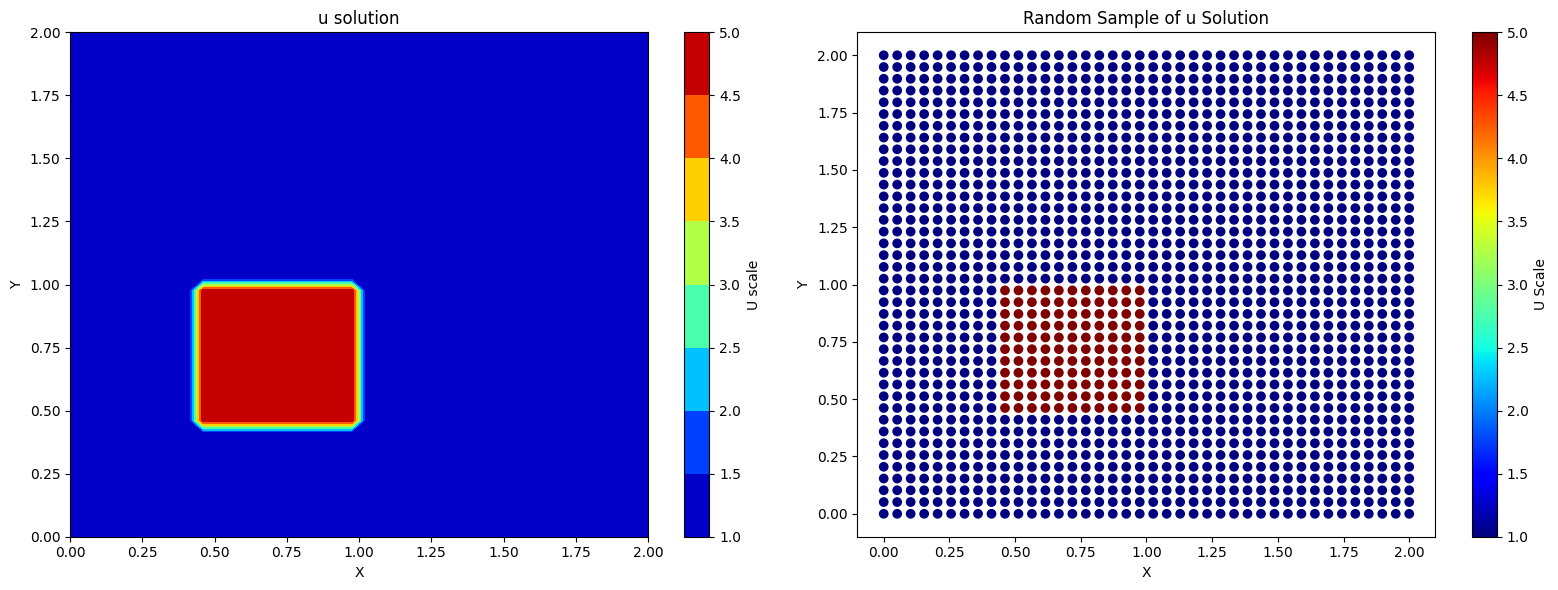

In [ ]:
# Convertir tensores a NumPy antes de graficar (transferencia GPU -> CPU)
u_initial_np = u_initial.cpu().detach().numpy()  # De GPU a CPU y a NumPy
v_initial_np = v_initial.cpu().detach().numpy()
x_initial_np = x_initial.cpu().detach().numpy()
y_initial_np = y_initial.cpu().detach().numpy()

# Graficar
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 fila, 2 columnas

# Primer subplot (gráfico de contorno)
contour = axes[0].contourf(
    X.cpu().detach().numpy(),  # X en NumPy
    Y.cpu().detach().numpy(),  # Y en NumPy
    u_initial_np.T,            # u_initial transpuesto
    cmap='jet'
)
axes[0].set_title('u solution')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
colorbar = plt.colorbar(contour, ax=axes[0])
colorbar.set_label('U scale')

# Segundo subplot (gráfico de dispersión)
im = axes[1].scatter(
    x_initial_np,  # Coordenadas X
    y_initial_np,  # Coordenadas Y
    c=v_initial_np,  # Color basado en valores de v_initial
    cmap='jet'
)
axes[1].set_title('Random Sample of u Solution')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
colorbar = plt.colorbar(im, ax=axes[1])  # Barra de colores para el scatter
colorbar.set_label('U Scale')

# Ajustar el diseño y mostrar los gráficos
plt.tight_layout()  # Ajustar los parámetros del diseño
plt.show()

In [ ]:
XX = torch.cat([X[X == 0], X[X == 2], X[Y == 0], X[Y == 2]]).cuda()
YY = torch.cat([Y[X == 0], Y[X == 2], Y[Y == 0], Y[Y == 2]]).cuda()

In [ ]:
# Create a tensor of size (len(XX), 2)
combined_tensor = torch.stack((XX, YY), dim=1).cuda()
np.shape(combined_tensor)

torch.Size([160, 2])

In [ ]:
XX = torch.cat([X[X==0], X[X==2], X[Y==0], X[Y==2]]).cuda()
YY = torch.cat([Y[X==0], Y[X==2], Y[Y==0], Y[Y==2]]).cuda()
# Create a tensor of size (len(XX), 2)
combined_tensor = torch.stack((XX, YY), dim=1).cuda()
# Remove duplicate pairs
boundary_tensor = torch.unique(combined_tensor, dim=0).cuda()

In [ ]:
# Asegurarse de que los tensores estén en la GPU
boundary_tensor = boundary_tensor.cuda()
t = t.cuda()

# Repetir el boundary_tensor en la GPU
repeated_boundary_tensor = boundary_tensor.repeat(Ntiempo, 1)

# Reestructurar para que coincidan con las dimensiones originales
x_boundary = repeated_boundary_tensor[:, 0].reshape(-1, 1).cuda()
y_boundary = repeated_boundary_tensor[:, 1].reshape(-1, 1).cuda()

# Crear t_boundary en la GPU
t_boundary = torch.repeat_interleave(t.reshape(-1, 1), len(boundary_tensor), dim=0).cuda()

# Verificar las formas finales de los tensores
print(x_boundary.shape)
print(y_boundary.shape)
print(t_boundary.shape)

torch.Size([15600, 1])
torch.Size([15600, 1])
torch.Size([15600, 1])


In [ ]:
u_boundary = torch.ones_like(x_boundary).cuda()
v_boundary = torch.ones_like(y_boundary).cuda()

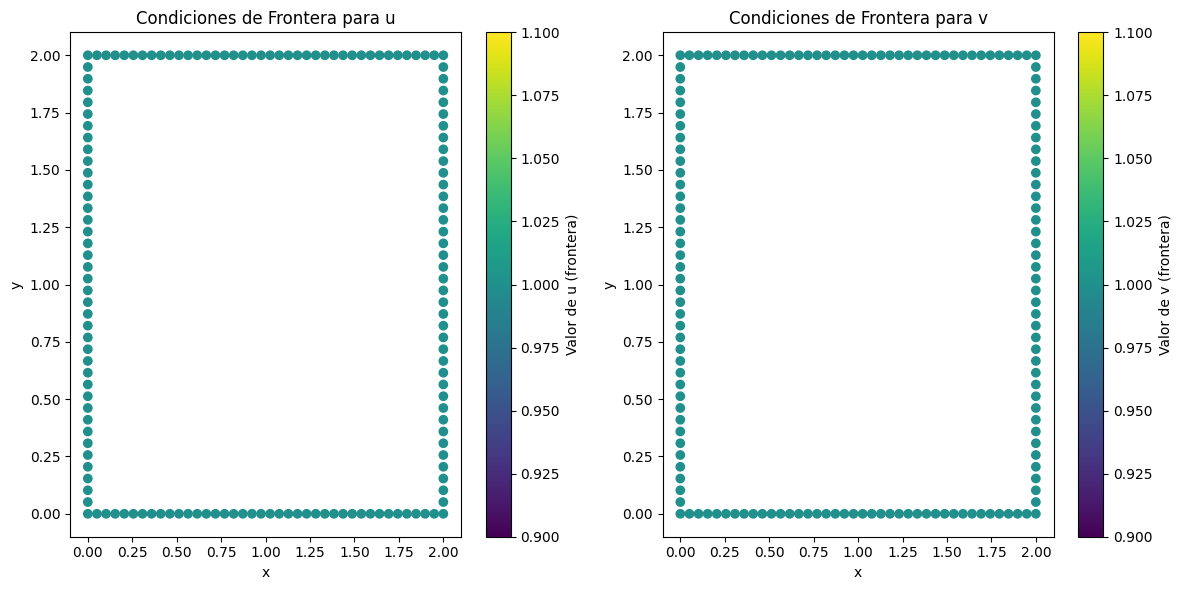

In [ ]:
# Transferir los tensores a la CPU antes de graficar
x_boundary_cpu = x_boundary.cpu().detach().numpy()
y_boundary_cpu = y_boundary.cpu().detach().numpy()
t_boundary_cpu = t_boundary.cpu().detach().numpy()
u_boundary_cpu = u_boundary.cpu().detach().numpy()
v_boundary_cpu = v_boundary.cpu().detach().numpy()

# Graficar las condiciones de frontera para u y v
plt.figure(figsize=(12, 6))

# Gráfico para la condición de frontera de u
plt.subplot(1, 2, 1)
plt.scatter(
    x_boundary_cpu[t_boundary_cpu == 0],
    y_boundary_cpu[t_boundary_cpu == 0],
    c=u_boundary_cpu[t_boundary_cpu == 0]
)
plt.title('Condiciones de Frontera para u')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='Valor de u (frontera)')

# Gráfico para la condición de frontera de v
plt.subplot(1, 2, 2)
plt.scatter(
    x_boundary_cpu[t_boundary_cpu == 0],
    y_boundary_cpu[t_boundary_cpu == 0],
    c=v_boundary_cpu[t_boundary_cpu == 0]
)
plt.title('Condiciones de Frontera para v')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='Valor de v (frontera)')

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()

In [ ]:
# Mover X, Y y t a la GPU si es necesario
X = X.cuda()
Y = Y.cuda()
t = t.cuda()

# Concatenar y dar forma a los tensores en la GPU
x_initial = torch.cat([x_initial]).reshape(-1, 1).cuda()
y_initial = torch.cat([y_initial]).reshape(-1, 1).cuda()

u_initial = torch.cat([u_initial]).reshape(-1, 1).cuda()
v_initial = torch.cat([v_initial]).reshape(-1, 1).cuda()

# Concatenar X y Y, luego repetirlos en la GPU
x = torch.cat([X]).reshape(-1, 1).repeat(len(t), 1).cuda()
y = torch.cat([Y]).reshape(-1, 1).repeat(len(t), 1).cuda()

# Crear t_ en la GPU
T_ = torch.repeat_interleave(t.reshape(-1, 1), nx*ny, dim=0).cuda()

In [ ]:
# Asegurarse de que todo se mueva a la GPU
T_ = T_.cuda()
u_initial = u_initial.cuda()

# Crear Z en la GPU
Z = T_.reshape(Ntiempo, nx, ny).cuda()

# Reshape u_initial en la GPU
uii = u_initial.reshape(nx, ny).cpu().detach().numpy()  # Convertir u_initial a NumPy, debe ser movido a CPU para esto

# Definir X y Y para la malla (asegurarse de que estén en GPU si es necesario)
meshgrid_X = X.cuda()
meshgrid_Y = Y.cuda()

In [ ]:
import plotly.graph_objects as go

# Asegurarse de que Z y u_initial estén en la GPU
Z = Z.cuda()  # Si Z es un tensor, lo movemos a la GPU

# Agregar un plano para cada valor de Z
uii = u_initial.reshape(nx, ny).cpu().detach().numpy()  # Convertir u_initial a NumPy, debe ser movido a CPU para la visualización
meshgrid_X = meshgrid_X.cpu().detach().numpy()  # Convertir a NumPy para la visualización
meshgrid_Y = meshgrid_Y.cpu().detach().numpy()  # Convertir a NumPy para la visualización

fig = go.Figure()

for i in range(0, len(Z), 10):
    _z_ = Z[i].cpu().detach().numpy()  # Mover _z_ a CPU para la visualización
    if i == 0:
        fig.add_trace(
            go.Surface(
                y=_z_,
                x=meshgrid_X,
                z=meshgrid_Y,
                opacity=0.5,  # Transparencia
                surfacecolor=uii.T,  # Azul
                showscale=False  # Ocultar escala de colores
            )
        )
    else:
        fig.add_trace(
            go.Surface(
                y=_z_,
                x=meshgrid_X,
                z=meshgrid_Y,
                colorscale=[[0, 'gray'], [1, 'gray']],
                opacity=0.3,  # Transparencia
                showscale=False  # Ocultar escala de colores
            )
        )

# Agregar scatter para cada valor de Z
for i in range(0, len(Z), 10):
    _z_ = Z[i].cpu().detach().numpy()  # Mover _z_ a CPU para la visualización
    fig.add_trace(
        go.Scatter3d(
            x=meshgrid_X.flatten(),
            z=meshgrid_Y.flatten(),
            y=_z_.flatten(),
            mode='markers',
            marker=dict(
                size=3,
                color=_z_.flatten(),  # Colorear puntos con valores de Z
                colorscale=[[0, 'gray'], [1, 'gray']],
                opacity=0.3           # Transparencia
            ),
            name="Scatter Points"
        )
    )

# Configurar diseño
fig.update_layout(
    title="Planos y Scatter en función de t",
    scene=dict(
        xaxis_title="X",
        yaxis_title="tiempo",
        zaxis_title="Y",
        xaxis=dict(showgrid=True),  # Mostrar grid en X
        yaxis=dict(showgrid=True),  # Mostrar grid en Y
        zaxis=dict(showgrid=True),  # Mostrar grid en Z
        aspectratio=dict(
            x=1,  # Alargar el eje X
            y=2,  # Eje Y permanece igual
            z=1   # Eje Z permanece igual
        )
    )
)

# Mostrar figura
fig.show()

In [ ]:
x = x.cuda().requires_grad_(True)
y = y.cuda().requires_grad_(True)
T_ = T_.cuda().requires_grad_(True)
x_boundary = x_boundary.cuda().requires_grad_(True)
y_boundary = y_boundary.cuda().requires_grad_(True)
t_boundary = t_boundary.cuda().requires_grad_(True)
u_boundary = u_boundary.cuda().requires_grad_(True)
v_boundary = v_boundary.cuda().requires_grad_(True)
x_initial = x_initial.cuda().requires_grad_(True)
y_initial = y_initial.cuda().requires_grad_(True)
t_initial = t_initial.cuda().requires_grad_(True)  # Si t_initial necesita gradientes
u_initial = u_initial.cuda().requires_grad_(True)
v_initial = v_initial.cuda().requires_grad_(True)

In [ ]:
nu = 0.1  # Viscosidad
w1= 0.01
w2= 0.5
w3= 0.4
num_epochs = 5000  # Número de épocas de entrenamiento
learning_rate = 1e-3  # Tasa de aprendizaje

checkpoint = {
    "epochs": [],
    "losses": [],
    "parameters": []  # Para guardar los parámetros de la red
}

# Crear el modelo y la función de pérdida
model = BurgerEquationNN().cuda()  # Mover el modelo a la GPU
criterion = PINNLoss(model, nu,w1,w2,w3).cuda()  # Mover la función de pérdida a la GPU
optimizer_model = optim.Adam(model.parameters(), lr=learning_rate)
optimizer_criterion = optim.Adam(criterion.parameters(), lr=learning_rate)



# Asegúrate de que todos los tensores estén en la GPU
x = x.cuda()
y = y.cuda()
T_ = T_.cuda()
x_boundary = x_boundary.cuda()
y_boundary = y_boundary.cuda()
t_boundary = t_boundary.cuda()
u_boundary = u_boundary.cuda()
v_boundary = v_boundary.cuda()
x_initial = x_initial.cuda()
y_initial = y_initial.cuda()
t_initial = t_initial.cuda()  # Si t_initial necesita gradientes
u_initial = u_initial.cuda()
v_initial = v_initial.cuda()

# Entrenamiento
for epoch in range(num_epochs):
    optimizer_model.zero_grad()
    optimizer_criterion.zero_grad()
    loss = criterion(x, y, T_, x_boundary, y_boundary, t_boundary, u_boundary, v_boundary, x_initial, y_initial, t_initial, u_initial, v_initial)
    loss.backward()
    optimizer_model.step()
    optimizer_criterion.step()

    criterion.w1.data.clamp_(min=0.001)
    criterion.w2.data.clamp_(min=0.1)
    criterion.w3.data.clamp_(min=0.009)

    # print(epoch)
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        print(f"Epoch {epoch}: w1 = {criterion.w1.item()}, w2 = {criterion.w2.item()}, w3 = {criterion.w3.item()}")
        params = {name: param.detach().clone().cpu().numpy() for name, param in model.named_parameters()}

        # Guardar los resultados en el checkpoint
        checkpoint["epochs"].append(epoch)
        checkpoint["losses"].append(loss.item())
        checkpoint["parameters"].append(params)

Epoch 0, Loss: 3.732576847076416
Epoch 0: w1 = 0.009025738574564457, w2 = 0.49900001287460327, w3 = 0.39900001883506775
Epoch 1000, Loss: 0.02778853289783001
Epoch 1000: w1 = 0.0010000000474974513, w2 = 0.4517255127429962, w3 = 0.10534807294607162


In [ ]:
nXtest = nx
nYtest = ny
nTtest = 500

xtest = torch.linspace(0, 2, nXtest).cuda()  # Mover a GPU
ytest = torch.linspace(0, 2, nYtest).cuda()  # Mover a GPU
t_test = torch.linspace(0, 0.5, nTtest).cuda()  # Mover a GPU
Xtest, Ytest = torch.meshgrid(xtest, ytest, indexing="ij")

x_t = torch.cat([Xtest]).reshape(-1,1).repeat(nTtest,1).cuda()  # Mover a GPU
y_t = torch.cat([Ytest]).reshape(-1,1).repeat(nTtest,1).cuda()  # Mover a GPU
t_t = torch.repeat_interleave(t_test.reshape(-1,1), nXtest*nYtest, dim=0).cuda()  # Mover a GPU

NameError: name 'nx' is not defined

In [ ]:
# Asegúrate de que el modelo esté en la GPU
model = model.cuda()

# Asegúrate de que los tensores estén en la GPU
x_t = x_t.cuda()
y_t = y_t.cuda()
t_t = t_t.cuda()

# Predicción
u_pred, v_pred = model(x_t, y_t, t_t)

In [ ]:
u_pred = u_pred.detach().cpu().numpy().reshape(nTtest, nXtest, nYtest)
v_pred = v_pred.detach().cpu().numpy().reshape(nTtest, nXtest, nYtest)

In [ ]:
np.shape(u_pred)

In [ ]:
# np.savetxt('datos1.txt',u_pred[-1])
# np.savetxt('datos0.txt',u_pred[0])
np.save("u_pinn.npy", u_pred)

In [ ]:
t_index = 0  # Índice de tiempo inicial, ajusta según sea necesario
U_slice = u_pred[t_index]
V_slice = v_pred[t_index]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 fila, 2 columnas

# Primer subplot (gráfico de contornos)
contour = axes[0].contourf(Xtest.cpu().detach().numpy(),
                           Ytest.cpu().detach().numpy(),
                           U_slice,
                           cmap='jet')  # .T no es necesario si las dimensiones son correctas
axes[0].set_title('u solution')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
colorbar = plt.colorbar(contour, ax=axes[0])
colorbar.set_label('U scale')

# Segundo subplot (gráfico de dispersión)
lim = nx*ny  # Ajusta esto según el rango deseado
im = axes[1].scatter(x_t[0:lim].cpu().detach().numpy(),
                     y_t[0:lim].cpu().detach().numpy(),
                     c=U_slice)  # Ajusta a c para que coincida con las dimensiones
axes[1].set_title('Random Sample of u Solution')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
colorbar = plt.colorbar(im, ax=axes[1])
colorbar.set_label('U Scale')

plt.tight_layout()  # Ajustar los parámetros del diseño
plt.show()

# Gráfico para el último índice de tiempo
t_index = -1  # Índice de tiempo final
U_slice = u_pred[t_index]
V_slice = v_pred[t_index]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 fila, 2 columnas

# Primer subplot (gráfico de contornos)
contour = axes[0].contourf(Xtest.cpu().detach().numpy(),
                           Ytest.cpu().detach().numpy(),
                           U_slice,
                           cmap='jet')
axes[0].set_title('u solution')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
colorbar = plt.colorbar(contour, ax=axes[0])
colorbar.set_label('U scale')

# Segundo subplot (gráfico de dispersión)
im = axes[1].scatter(x_t[:lim].cpu().detach().numpy(),
                     y_t[:lim].cpu().detach().numpy(),
                     c=U_slice.flatten())  # Ajusta a c para que coincida con las dimensiones
axes[1].set_title('Random Sample of u Solution')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
colorbar = plt.colorbar(im, ax=axes[1])
colorbar.set_label('U Scale')

plt.tight_layout()
plt.show()


In [ ]:
meshgrid_X, meshgrid_Y = Xtest.cpu().detach().numpy(), Ytest.cpu().detach().numpy()

t_index = 0 # Example index, adjust as needed
U_slice = u_pred[t_index]
V_slice = v_pred[t_index]

In [ ]:
Z = t_t.reshape(nTtest, nXtest, nYtest)

In [ ]:
fig = go.Figure()

# Agregar un plano para cada valor de Z
uii = u_initial.reshape(nx, ny).cpu().detach().numpy()
for t_index in range(0, 500,100):
    _z_= Z[t_index].cpu().detach().numpy()
    fig.add_trace(
        go.Surface(
            y=_z_,
            x=meshgrid_X,
            z=meshgrid_Y,
            opacity=0.5,  # Transparencia
            surfacecolor= u_pred[t_index],  # Azul
            showscale=False  # Ocultar escala de colores
        )
    )

# Configurar diseño
fig.update_layout(
    title="Planos y Scatter en función de t",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z",
        xaxis=dict(showgrid=True),  # Mostrar grid en X
        yaxis=dict(showgrid=True),  # Mostrar grid en Y
        zaxis=dict(showgrid=True),   # Mostrar grid en Z
        aspectratio=dict(
            x=1,  # Alargar el eje X
            y=2,  # Eje Y permanece igual
            z=1   # Eje Z permanece igual
        )
    )
)

# Mostrar figura
fig.show()


In [ ]:
plt.figure(figsize=(10, 6))  # Configura el tamaño de la figura
plt.plot(checkpoint["epochs"], checkpoint["losses"])  # Grafica las épocas frente a las pérdidas
plt.xlabel("Epoch")  # Etiqueta del eje X
plt.ylabel("Loss")  # Etiqueta del eje Y
plt.title("Learning Curve")  # Título del gráfico
plt.grid(True)  # Agrega una cuadrícula al gráfico para mejor visualización
plt.ylim(0, 1)  # Define el rango del eje Y para pérdidas
plt.show()  # Muestra el gráfico
